## Configuration

### 1. Importing Libraries

In [1]:
# Core libraries
import numpy as np
import pandas as pd
import polars as pl
from tqdm import tqdm
from pathlib import Path
import random

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

# Machine Learning libraries
import lightgbm as lgb
from catboost import CatBoostRegressor, Pool
from xgboost import XGBRegressor
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import KFold, StratifiedKFold

# Additional libraries
import statsmodels.api as sm  # For statistical analysis if needed
import nbformat  # For Jupyter notebook compatibility
import pyarrow as pa  # For advanced data handling

### 2. Creating Configurations

In [2]:
class CFG:
    train_path = Path('../data/external/train.csv')
    test_path = Path('../data/external/test.csv')
    subm_path = Path('../data/external/sample_submission.csv')
    leak_path = Path('../data/external/AmesHousing.csv')
    
    train_df = pd.read_csv(str(train_path))
    test_df = pd.read_csv(str(test_path))
    
    train_df.name = 'train_df'
    test_df.name = 'test.df'
    
    use_leak = True
    
    color = '#F08000'
    lgb_weight = 0.20
    ctb_weight = 0.20
    xgb_weight = 0.20
    ridge_weight = 0.20
    rfr_weight = 0.20
    early_stop = 50
    n_splits = 15
    
    lgb_params = {
        'objective': 'regression',
        'min_child_samples': 24,
        'num_iterations': 4000,
        'learning_rate': 0.03,
        'extra_trees': True,
        'reg_lambda': 0.8,
        'reg_alpha': 0.08,
        'num_leaves': 64,
        'metric': 'rmse',
        'device': 'cpu',
        'max_bin': 128,
        'max_depth': 4,
        'verbose': -1,
        'seed': 42
    }
    
    ctb_params = {
        'grow_policy': 'Depthwise',
        'loss_function': 'RMSE',
        'min_child_samples': 4,
        'learning_rate': 0.03,
        'random_state': 42,
        'task_type': 'CPU',
        'reg_lambda': 0.8,
        'num_trees': 4000,
        'depth': 4
    }
    
    xgb_params = {
        'objective': 'reg:squarederror',
        'learning_rate': 0.03,
        'max_depth': 4,
        'n_estimators': 4000,
        'reg_lambda': 0.8,
        'reg_alpha': 0.08,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'seed': 42,
        'verbosity': 0
    }
    
    ridge_params = {
        'alpha': 1.0,  
        'solver': 'auto', 
        'random_state': 42
    }
    
    rfr_params = {
        'n_estimators': 1000,
        'max_depth': 10,
        'min_samples_split': 2,
        'min_samples_leaf': 1,
        'max_features': 'auto',
        'bootstrap': True,
        'random_state': 42,
        'n_jobs': -1 
    }

In [3]:
num_cols = CFG.train_df.select_dtypes(include=['int64', 'float64']).columns
cat_cols = CFG.train_df.select_dtypes(include=['object']).columns

## Outliers Removal

In [4]:
# Z-score Method
def remove_outliers_zscore(df, numeric_cols, threshold=3):
    keep_rows = pd.Series([True] * len(df))
    
    for col in numeric_cols:
        col_z_scores = (df[col] - df[col].mean()) / df[col].std()  # Standardize the column
        keep_rows &= (col_z_scores.abs() < threshold)  # Mark rows that meet the threshold for this column
    
    df_zscore_cleaned = df[keep_rows]  # Apply mask to the df
    print(f"Removed {len(df) - len(df_zscore_cleaned)} outliers based on Z-score threshold of {threshold}")
    return df_zscore_cleaned

# IQR Method
def remove_outliers_iqr(df, numeric_cols, multiplier=1.5):
    Q1 = df[numeric_cols].quantile(0.25)
    Q3 = df[numeric_cols].quantile(0.75)
    IQR = Q3 - Q1
    
    df_iqr_cleaned = df[~((df[numeric_cols] < (Q1 - multiplier * IQR)) | 
                          (df[numeric_cols] > (Q3 + multiplier * IQR))).any(axis=1)]
    
    print(f"Removed {len(df) - len(df_iqr_cleaned)} outliers based on IQR multiplier of {multiplier}")
    return df_iqr_cleaned

In [5]:
train_df_zscore_cleaned = remove_outliers_zscore(CFG.train_df, num_cols, threshold=3)
train_df_iqr_cleaned = remove_outliers_iqr(CFG.train_df, num_cols, multiplier=1.5)

Removed 664 outliers based on Z-score threshold of 3
Removed 897 outliers based on IQR multiplier of 1.5


### Visualize Changes

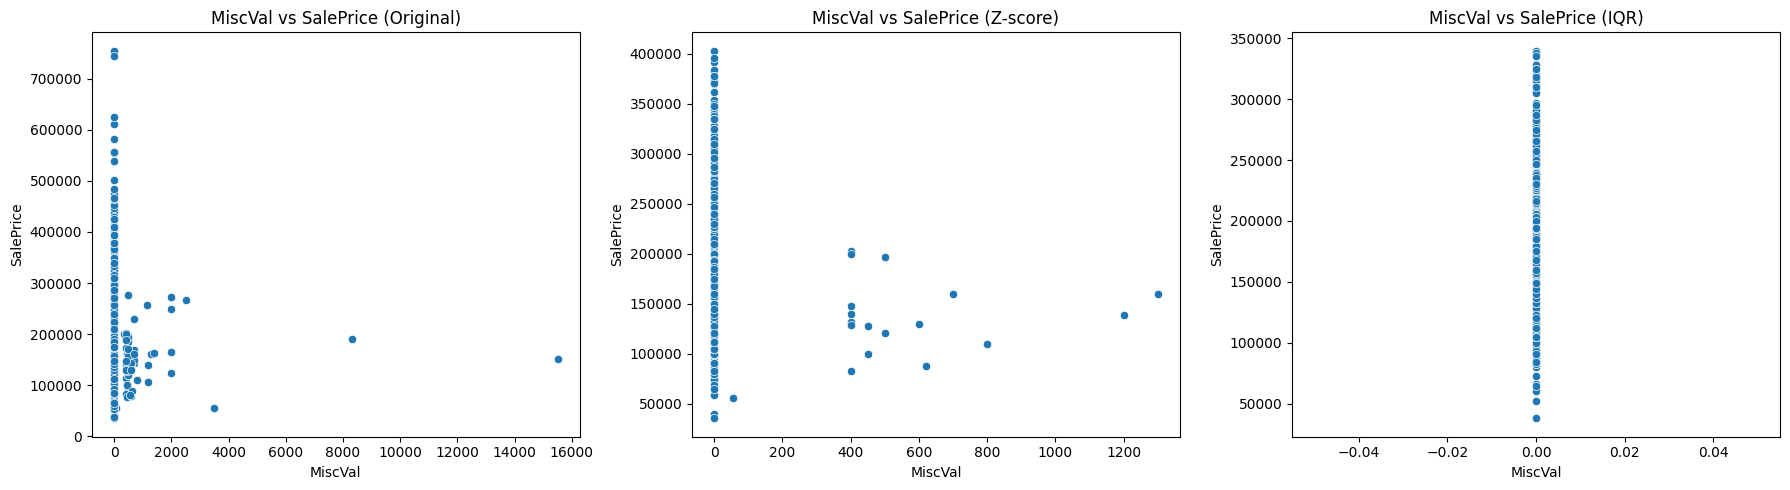

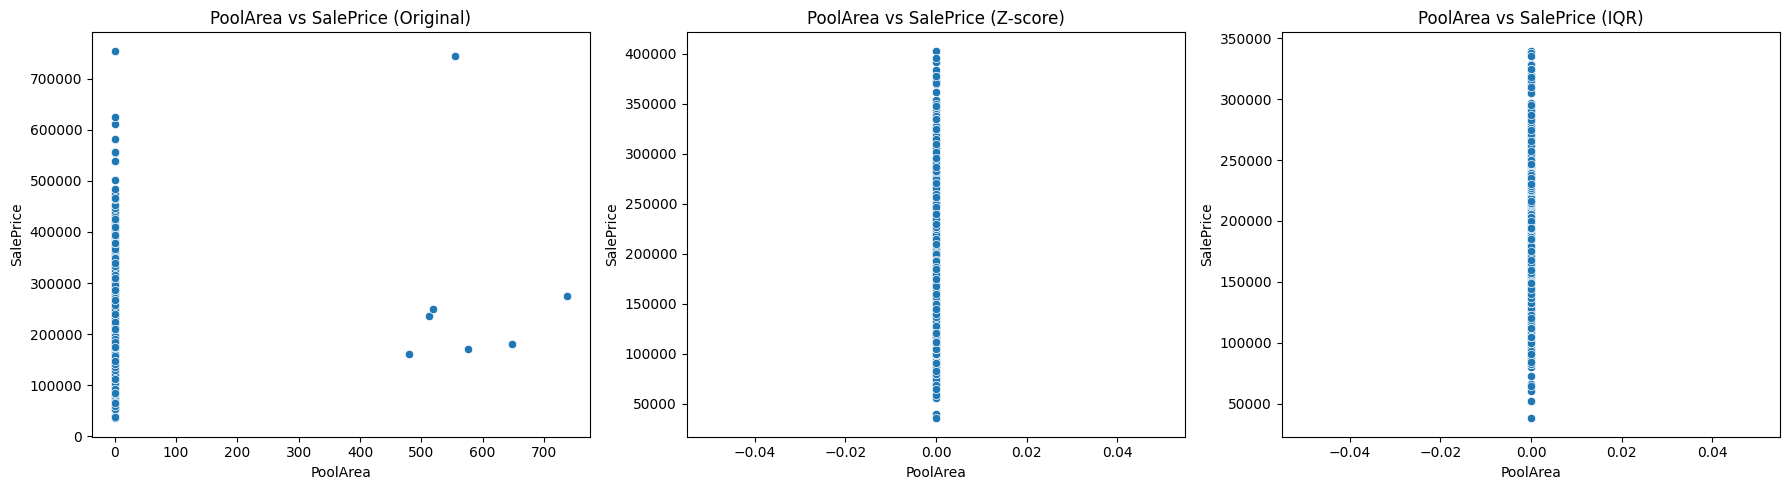

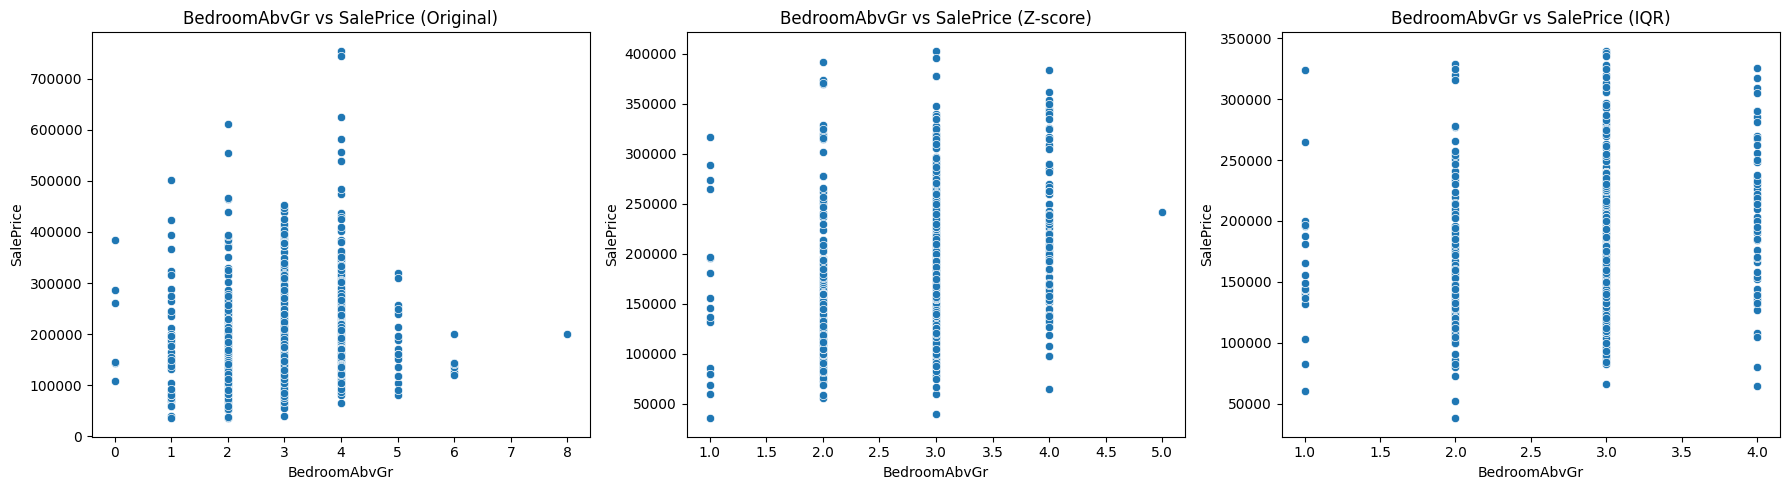

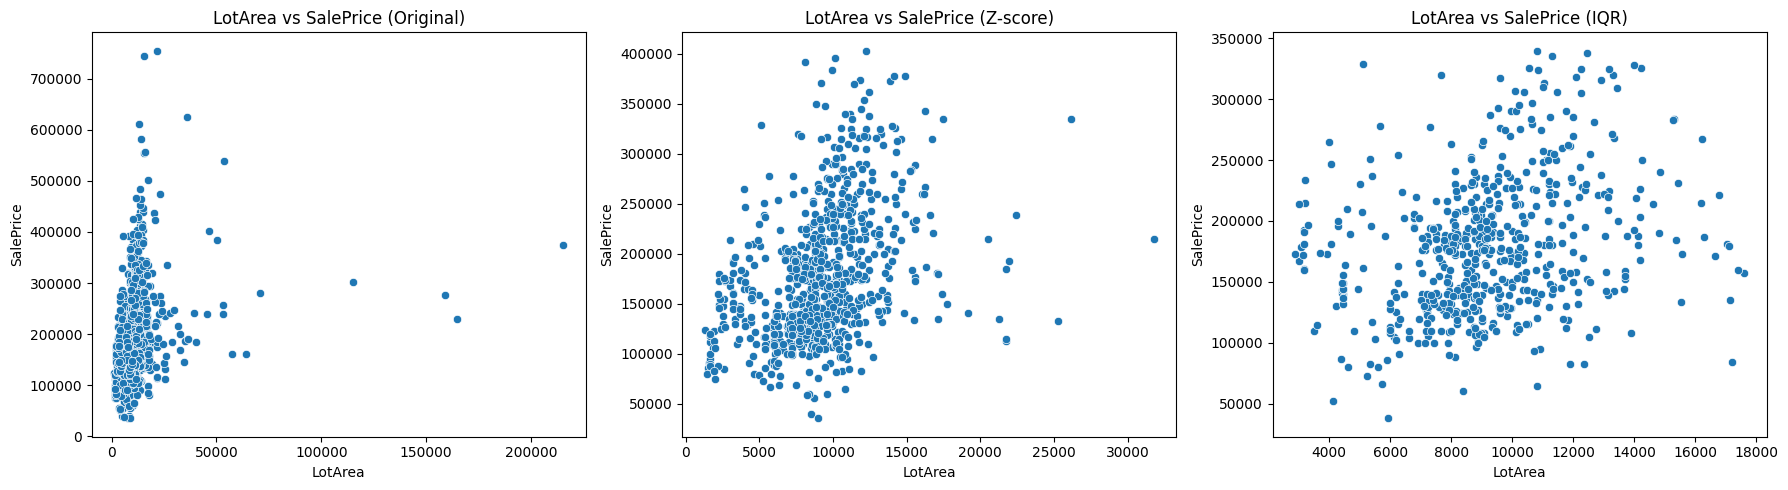

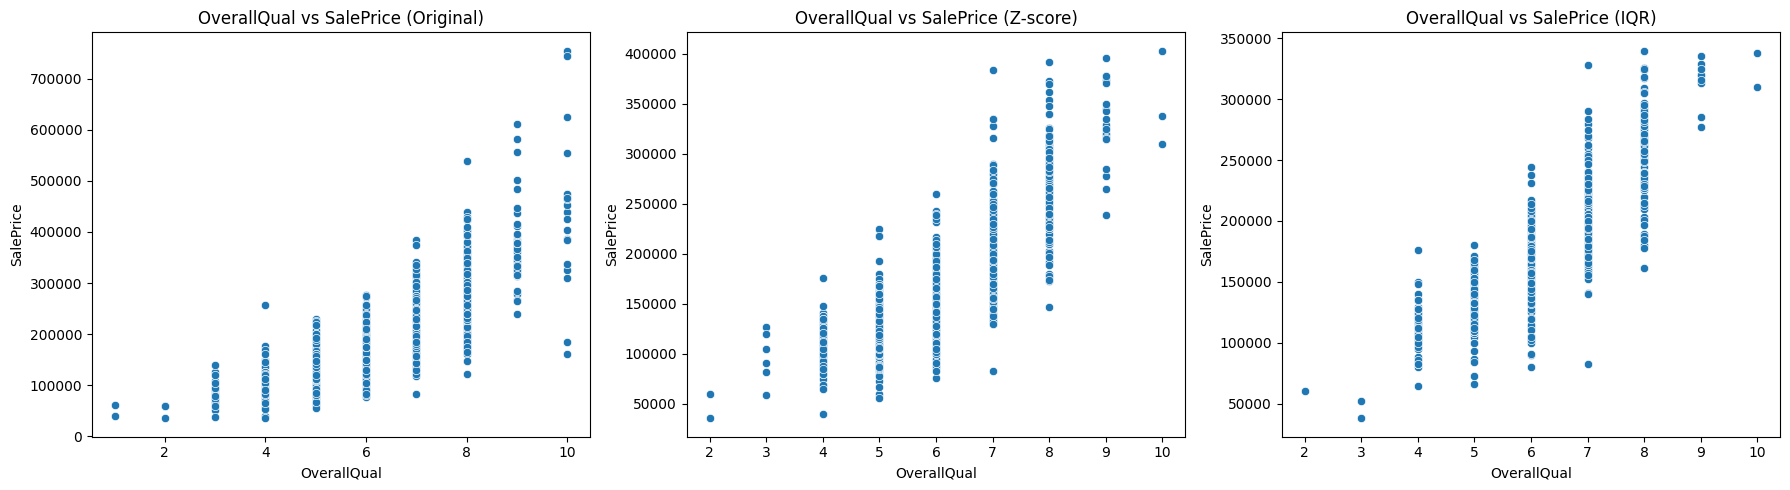

In [6]:
def plot_outlier_comparison(df_original, df_zscore_cleaned, df_iqr_cleaned, target='SalePrice', n=5):
    sample_columns = random.sample(list(num_cols), n)
    
    for col in sample_columns:
        plt.figure(figsize=(18, 5))
        
        # Original data
        plt.subplot(1, 3, 1)
        sns.scatterplot(x=df_original[col], y=df_original[target])
        plt.title(f"{col} vs {target} (Original)")
        
        # Z-score
        plt.subplot(1, 3, 2)
        sns.scatterplot(x=df_zscore_cleaned[col], y=df_zscore_cleaned[target])
        plt.title(f"{col} vs {target} (Z-score)")
        
        # IQR
        plt.subplot(1, 3, 3)
        sns.scatterplot(x=df_iqr_cleaned[col], y=df_iqr_cleaned[target])
        plt.title(f"{col} vs {target} (IQR)")
        
        plt.tight_layout()
        plt.show()
        
plot_outlier_comparison(CFG.train_df, train_df_zscore_cleaned, train_df_iqr_cleaned)

## Feature Engineering

Let's apply Feature Engineering to enhance the dataset by creating new variables that capture meaningful relationships and attributes of the houses, with the goal of enriching the information available for the model and improving predictive performance.

I'll construct additional features, such as total bathrooms, age of the house, and total porch area, to represent complex aspects of each property in a way that’s more accessible for the model. These engineered features are designed to leverage insights from Exploratory Data Analysis (EDA), setting up a more informative dataset to strengthen the modeling phase that follows.

In [18]:
class FE:
    
    def load_data(self, path=None, df=None):
        # If a DataFrame is provided, use it directly, otherwise load from path
        if df is not None:
            df = df
        elif path is not None:
            df = pl.read_csv(path, null_values='NA')
            df = df.drop('Id')
        else:
            raise ValueError("Either a DataFrame or a file path must be provided.")
        
        # Fill missing values for numeric and categorical columns
        for col in df.columns:
            if col in num_cols:
                df = df.with_columns(pl.col(col).fill_null(pl.col(col).mode().first()))
                df = df.with_columns(pl.col(col).cast(pl.Int64))
            else:
                df = df.with_columns(pl.col(col).fill_null('Unknown'))
                df = df.with_columns(pl.col(col).cast(pl.Categorical))
        
        return df
    
    def remove_outliers(self, df, method='zscore', threshold=3, multiplier=1.5):
        df = df.to_pandas()  # Convert to pandas for compatibility with outlier functions
        
        if method == 'zscore':
            df = remove_outliers_zscore(df, num_cols, threshold)
        elif method == 'iqr':
            df = remove_outliers_iqr(df, num_cols, multiplier)
        
        print(f"Data shape after outlier removal: {df.shape}")
        return pl.from_pandas(df)  # Convert back to polars DataFrame

    def aggregate_data(self, df):
        df = df.with_columns([
            pl.col('BsmtFullBath').add(pl.col('FullBath'))
            .add(0.5 * (pl.col('BsmtHalfBath') + pl.col('HalfBath')))
            .alias('totalbaths'),
            
            pl.col('OpenPorchSF').add(pl.col('3SsnPorch'))
            .add(pl.col('EnclosedPorch'))
            .add(pl.col('ScreenPorch'))
            .add(pl.col('WoodDeckSF'))
            .alias('totalporchsf'),
            
            pl.col('TotRmsAbvGrd').add(pl.col('FullBath'))
            .add(pl.col('HalfBath'))
            .alias('totalrooms'),
            
            pl.col('YrSold').sub(pl.col('YearBuilt'))
            .alias('houseage'),
            
            pl.col('YrSold').sub(pl.col('YearRemodAdd'))
            .alias('houseremodelage'),
            
            pl.col('1stFlrSF').add(pl.col('2ndFlrSF'))
            .add(pl.col('BsmtFinSF1'))
            .add(pl.col('BsmtFinSF2'))
            .alias('totalsf'),
            
            pl.col('GrLivArea').add(pl.col('TotalBsmtSF'))
            .alias('totalarea'),
            
            pl.lit(2020).sub(pl.col('GarageYrBlt').fill_null(0))
            .alias('garageage'),
            
            pl.col('BsmtFinSF1').add(pl.col('BsmtFinSF2'))
            .add(pl.col('BsmtUnfSF'))
            .alias('totalbasementarea'),
            
            pl.col('OverallQual').mul(pl.col('OverallCond'))
            .alias('quality_condition_interaction'),
        ])
    
        df = df.with_columns([
            pl.col('YrSold').sub(pl.col(col))
            .cast(pl.Int64).alias(f'YrSold_{col}_diff') 
            for col in ['YearBuilt', 'YearRemodAdd', 'GarageYrBlt']
        ])
        
        df = df.with_columns([
            pl.col('YearRemodAdd').sub(pl.col(col))
            .cast(pl.Int64).alias(f'YearRemodAdd_{col}_diff') 
            for col in ['YearBuilt', 'GarageYrBlt']
        ])
        
        return df

    def extract_cat_cols(self, df):
        cat_cols = []
        for col in df.columns:
            if df[col].dtype == pl.Categorical:
                cat_cols.append(col)
        return cat_cols

    def display_info(self, df):
        print(f'Shape: {df.shape}')
        mem = df.memory_usage().sum() / 1024**2
        print('Memory usage: {:.2f} MB\n'.format(mem))
        display(df.head())

    def process_data(self, path=None, df=None, outlier_method='zscore', threshold=3, multiplier=1.5):
        # Use either the provided path or DataFrame
        df = self.load_data(path=path, df=df)
        df = self.remove_outliers(df, method=outlier_method, threshold=threshold, multiplier=multiplier)
        df = self.aggregate_data(df)
        cat_cols = self.extract_cat_cols(df)
        df = df.to_pandas()
        self.display_info(df)
        return df, cat_cols

fe = FE()

In [20]:
train_data, cat_cols = fe.process_data(df=CFG.train_df)  # Using train_df directly

AttributeError: 'DataFrame' object has no attribute 'with_columns'

In [9]:
test_data, _ = fe.process_data(CFG.test_path)

Shape: (1459, 94)
Memory usage: 0.64 MB



,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,totalsf,totalarea,garageage,totalbasementarea,quality_condition_interaction,YrSold_YearBuilt_diff,YrSold_YearRemodAdd_diff,YrSold_GarageYrBlt_diff,YearRemodAdd_YearBuilt_diff,YearRemodAdd_GarageYrBlt_diff
0,20,RH,80.0,11622,Pave,Unknown,Reg,Lvl,AllPub,Inside,...,1508,1778,59,882,30,49,49,49.0,0,0.0
1,20,RL,81.0,14267,Pave,Unknown,IR1,Lvl,AllPub,Corner,...,2252,2658,62,1329,36,52,52,52.0,0,0.0
2,60,RL,74.0,13830,Pave,Unknown,IR1,Lvl,AllPub,Inside,...,2420,2557,23,928,25,13,12,13.0,1,1.0
3,60,RL,78.0,9978,Pave,Unknown,IR1,Lvl,AllPub,Inside,...,2206,2530,22,926,36,12,12,12.0,0,0.0
4,120,RL,43.0,5005,Pave,Unknown,IR1,HLS,AllPub,Inside,...,1543,2560,28,1280,40,18,18,18.0,0,0.0


## Implementing Log Transformation on 'SalePrice'

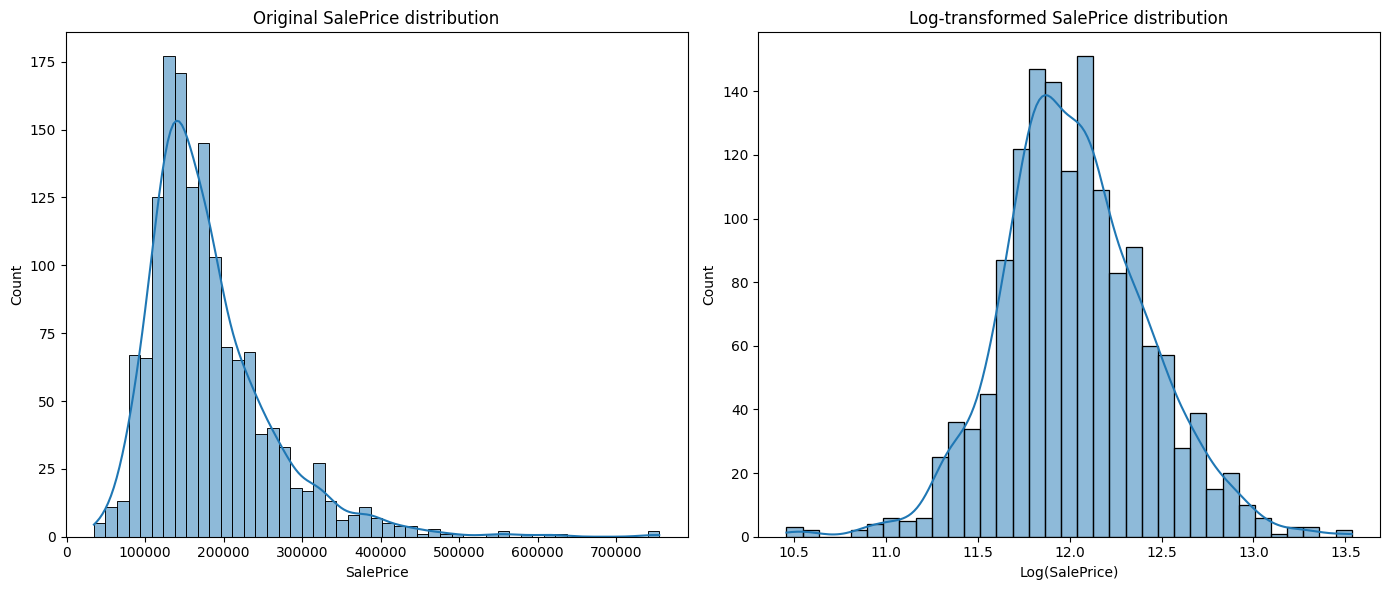

In [10]:
def plot_saleprice_distribution(df):
    plt.figure(figsize=(14,6))
    
    # Original SalePrice
    plt.subplot(1, 2, 1)
    sns.histplot(df['SalePrice'], kde=True)
    plt.title("Original SalePrice distribution")
    plt.xlabel("SalePrice")
    
    # Log-transformed SalePrice
    plt.subplot(1, 2, 2)
    sns.histplot(np.log1p(df['SalePrice']), kde=True)
    plt.title("Log-transformed SalePrice distribution")
    plt.xlabel("Log(SalePrice)")
    
    plt.tight_layout()
    plt.show()
    
plot_saleprice_distribution(CFG.train_df)

CFG.train_df['SalePrice'] = np.log1p(CFG.train_df['SalePrice'])

## Exploratory Data Analysis (EDA)

Lets perform EDA to better understand the features within the dataset and their relationships with the target variable, SalePrice, to identify patterns and correlations that could guide effective feature engineering and improve the model's predictive performance.

I'll analyze key variables through visualizations, such as scatter plots and a correlation matrix, to uncover trends and check for any outliers or unusual distributions. This analysis will inform my decisions on which features to transform, retain, or modify, setting a strong foundation for the modeling phase that follows.

In [11]:
class EDA:
    
    def __init__(self, df, cat_cols):
        self.df = df
        self.cat_cols = cat_cols
    
    def template(self, fig, title):
        
        # Set background in accordance to user theme (light, dark)
        fig.update_layout(
            title=title,
            title_x=0.5,
            plot_bgcolor='rgba(0,0,0,0)',
            paper_bgcolor='rgba(0,0,0,0)',
            font=dict(color='#7f7f7f'),
            margin=dict(l=90, r=90, t=90, b=90),
            height=900
        )
        
        return fig

    def saleprice_scatter_plot(self, x_column):
        
        # Create a scatter plot for SalePrice vs another feature
        fig = px.scatter(
            self.df,
            x=x_column,
            y='SalePrice', 
            trendline='ols',
            labels={x_column: x_column, 'SalePrice': 'Sale Price'},
            title=f'Scatter Plot: {x_column} vs SalePrice',
            template='plotly'
        )

        fig = self.template(fig, f'Scatter Plot: {x_column} vs SalePrice')
        
        fig.show()

    def correlation_matrix(self, colorscale):
        
        # Exclude categorical columns for correlation matrix calculation
        num_df = self.df.drop(columns=self.cat_cols)

        # Calculate the correlation matrix
        corr = num_df.corr()

        # Create a heatmap without annotations (no numbers in the boxes)
        fig = go.Figure(data=go.Heatmap(
            z=corr.values,
            x=corr.columns,
            y=corr.index,
            colorscale=colorscale,
            hoverinfo='z'  # Show only the correlation value on hover
        ))

        # Apply the template
        fig = self.template(fig, 'Correlation Matrix')

        # Update axes
        fig.update_xaxes(title_text='Features')
        fig.update_yaxes(title_text='Features')

        # Show correlation matrix
        fig.show()
        
    def saleprice_distribution(self, color):

        bin_width = 10000 

        # Create a histogram with more legible bins
        fig = px.histogram(
            self.df,
            x='SalePrice',
            labels={'SalePrice': 'Sale Price'},
            title='Distribution of Sale Prices',
            color_discrete_sequence=[color],
            nbins=int((self.df['SalePrice'].max() - self.df['SalePrice'].min()) / bin_width), 
            opacity=0.7  
        )

        fig.update_layout(
            xaxis=dict(
                tickformat='$,.0f', 
                tickangle=45 
            ),
            bargap=0.1,  
        )

        fig = self.template(fig, 'Distribution of Sale Prices')

        fig.show()

eda = EDA(train_data, cat_cols)

In [12]:
eda.saleprice_scatter_plot('LotArea')
eda.saleprice_scatter_plot('GarageArea')
eda.saleprice_scatter_plot('YearBuilt')
eda.saleprice_scatter_plot('YearRemodAdd')
eda.correlation_matrix('peach')
eda.saleprice_distribution('#5F8575')

## Model Development

Lets create a class to handle training, evaluation, and inference using two specific machine learning models: LightGBM and CatBoost.

In [13]:
class MD:
    
    def __init__(self, 
                 lgb_params, 
                 ctb_params, 
                 xgb_params, 
                 ridge_params, 
                 rfr_params, 
                 lgb_weight, 
                 ctb_weight, 
                 xgb_weight,
                 ridge_weight,
                 rfr_weight,
                 early_stop,
                 n_splits,
                 color):

        self.lgb_params = lgb_params
        self.ctb_params = ctb_params
        self.xgb_params = xgb_params
        self.ridge_params = ridge_params
        self.rfr_params = rfr_params
        self.lgb_weight = lgb_weight
        self.ctb_weight = ctb_weight
        self.xgb_weight = xgb_weight
        self.ridge_weight = ridge_weight
        self.rfr_weight = rfr_weight
        self.early_stop = early_stop
        self.n_splits = n_splits
        self.color = color
        
    def plot_cv(self, fold_scores, model_name):
        fold_scores = [round(score, 2) for score in fold_scores]
        mean_score = round(np.mean(fold_scores), 2)
        std_score = round(np.std(fold_scores), 2)

        fig = go.Figure()

        fig.add_trace(go.Scatter(
            x=list(range(1, len(fold_scores) + 1)),
            y=fold_scores,
            mode='markers',
            name='Fold Scores',
            marker=dict(size=24, color=self.color, symbol='diamond'),
            text=[f'{score:.2f}' for score in fold_scores],
            hovertemplate='Fold %{x}: %{text}<extra></extra>',
            hoverlabel=dict(font=dict(size=16))
        ))

        fig.add_trace(go.Scatter(
            x=[1, len(fold_scores)],
            y=[mean_score, mean_score],
            mode='lines',
            name=f'Mean: {mean_score:.2f}',
            line=dict(dash='dash', color='#D2042D'),
            hoverinfo='none'
        ))

        fig.update_layout(
            title=f'{model_name} Cross-Validation RMSE Scores | Variation of CV scores: {mean_score} ± {std_score}',
            xaxis_title='Fold',
            yaxis_title='RMSE Score',
            plot_bgcolor='rgba(0,0,0,0)',
            paper_bgcolor='rgba(0,0,0,0)',
            xaxis=dict(
                gridcolor='lightgray',
                tickmode='linear',
                tick0=1,
                dtick=1,
                range=[0.5, len(fold_scores) + 0.5]
            ),
            yaxis=dict(gridcolor='lightgray')
        )

        fig.show()

    def train_xgb(self, X, y, title):
        cv = KFold(n_splits=self.n_splits, shuffle=True, random_state=42)
        models, scores = [], []
        oof_preds = np.zeros(len(X))
        
        for fold, (train_index, valid_index) in enumerate(cv.split(X, y)):
            X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
            y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
            
            model = XGBRegressor(**self.xgb_params)
            model.fit(X_train, y_train,
                      eval_set=[(X_valid, y_valid)],
                      eval_metric='rmse',
                      early_stopping_rounds=self.early_stop,
                      verbose=0)
            
            models.append(model)
            oof_preds[valid_index] = model.predict(X_valid)
            score = mse(y_valid, oof_preds[valid_index], squared=False)
            scores.append(score)
        
        self.plot_cv(scores, title)
        return models, oof_preds

    def train_ridge(self, X, y, title):
        cv = KFold(n_splits=self.n_splits, shuffle=True, random_state=42)
        models, scores = [], []
        oof_preds = np.zeros(len(X))
        
        for fold, (train_index, valid_index) in enumerate(cv.split(X, y)):
            X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
            y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
            
            model = Ridge(**self.ridge_params)
            model.fit(X_train, y_train)
            
            models.append(model)
            oof_preds[valid_index] = model.predict(X_valid)
            score = mse(y_valid, oof_preds[valid_index], squared=False)
            scores.append(score)
        
        self.plot_cv(scores, title)
        return models, oof_preds

    def train_rfr(self, X, y, title):
        cv = KFold(n_splits=self.n_splits, shuffle=True, random_state=42)
        models, scores = [], []
        oof_preds = np.zeros(len(X))
        
        for fold, (train_index, valid_index) in enumerate(cv.split(X, y)):
            X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
            y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
            
            model = RandomForestRegressor(**self.rfr_params)
            model.fit(X_train, y_train)
            
            models.append(model)
            oof_preds[valid_index] = model.predict(X_valid)
            score = mse(y_valid, oof_preds[valid_index], squared=False)
            scores.append(score)
        
        self.plot_cv(scores, title)
        return models, oof_preds
    
    def train_lgb(self, X, y, cat_cols, title):
        for col in cat_cols:
            X[col] = X[col].astype('category')
        
        cv = KFold(n_splits=self.n_splits, shuffle=True, random_state=42)
        models, scores = [], []
        oof_preds = np.zeros(len(X))
        
        for fold, (train_index, valid_index) in enumerate(cv.split(X, y)):
            X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
            y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
            
            model = lgb.LGBMRegressor(**self.lgb_params)
            
            model.fit(X_train, y_train,
                    eval_set=[(X_valid, y_valid)],
                    eval_metric='rmse',
                    early_stopping_rounds=self.early_stop,
                    verbose=0)
            
            models.append(model)
            oof_preds[valid_index] = model.predict(X_valid)
            score = mse(y_valid, oof_preds[valid_index], squared=False)
            scores.append(score)
        
        self.plot_cv(scores, title)
        return models, oof_preds
    
    def train_ctb(self, X, y, cat_cols, title):
        for col in cat_cols:
            X[col] = X[col].astype(str)

        cat_features_indices = [X.columns.get_loc(col) for col in cat_cols]
        
        cv = KFold(n_splits=self.n_splits, shuffle=True, random_state=42)
        models, scores = [], []
        oof_preds = np.zeros(len(X))

        for fold, (train_index, valid_index) in enumerate(cv.split(X, y)):
            X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
            y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]

            model = CatBoostRegressor(**self.ctb_params, verbose=0)

            model.fit(X_train, y_train,
                    eval_set=(X_valid, y_valid),
                    early_stopping_rounds=self.early_stop,
                    verbose=0,
                    cat_features=cat_features_indices) 

            models.append(model)
            oof_preds[valid_index] = model.predict(X_valid)
            score = mse(y_valid, oof_preds[valid_index], squared=False)
            scores.append(score)

        self.plot_cv(scores, title)
        return models, oof_preds



    # Inference methods
    def infer_xgb(self, data, models):
        return np.mean([model.predict(data) for model in models], axis=0)

    def infer_ridge(self, data, models):
        return np.mean([model.predict(data) for model in models], axis=0)

    def infer_rfr(self, data, models):
        return np.mean([model.predict(data) for model in models], axis=0)

    def generate_preds(self, train, test, cat_cols):
        X = train.drop(['SalePrice'], axis=1)
        y = train['SalePrice']
        
        # Training each model
        lgb_models, oof_lgb_preds = self.train_lgb(X, y, cat_cols, 'LightGBM')
        ctb_models, oof_ctb_preds = self.train_ctb(X, y, cat_cols, 'CatBoost')
        xgb_models, oof_xgb_preds = self.train_xgb(X, y, cat_cols, 'XGBoost')
        ridge_models, oof_ridge_preds = self.train_ridge(X, y, 'Ridge')
        rfr_models, oof_rfr_preds = self.train_rfr(X, y, 'Random Forest')
        
        # Combining predictions with weights
        valid_preds = (oof_lgb_preds * self.lgb_weight +
                       oof_ctb_preds * self.ctb_weight +
                       oof_xgb_preds * self.xgb_weight +
                       oof_ridge_preds * self.ridge_weight +
                       oof_rfr_preds * self.rfr_weight)
        
        valid_rmse = mse(y, valid_preds, squared=False)
        print(f'RMSE score of the Ensemble: {round(valid_rmse, 2)}')
        
        # Test predictions for each model
        test_lgb_preds = self.infer_lgb(test, cat_cols, lgb_models)
        test_ctb_preds = self.infer_ctb(test, cat_cols, ctb_models)
        test_xgb_preds = self.infer_xgb(test, xgb_models)
        test_ridge_preds = self.infer_ridge(test, ridge_models)
        test_rfr_preds = self.infer_rfr(test, rfr_models)
        
        test_preds = (test_lgb_preds * self.lgb_weight +
                      test_ctb_preds * self.ctb_weight +
                      test_xgb_preds * self.xgb_weight +
                      test_ridge_preds * self.ridge_weight +
                      test_rfr_preds * self.rfr_weight)
        
        return test_preds

## Make Predictions

In [14]:
md = MD(
    lgb_params=CFG.lgb_params,
    ctb_params=CFG.ctb_params,
    xgb_params=CFG.xgb_params,
    ridge_params=CFG.ridge_params,
    rfr_params=CFG.rfr_params,
    lgb_weight=CFG.lgb_weight,
    ctb_weight=CFG.ctb_weight,
    xgb_weight=CFG.xgb_weight,
    ridge_weight=CFG.ridge_weight,
    rfr_weight=CFG.rfr_weight,
    early_stop=CFG.early_stop,
    n_splits=CFG.n_splits,
    color=CFG.color
)

In [15]:
# Step 1: Extract features (X) and target (y) from the training data
X_train = train_data.drop(columns=['SalePrice'])
y_train = train_data['SalePrice']

# Step 2: Use MD to train models and get predictions
# Training on the train_data, with categorical columns from cat_cols
train_models, oof_preds = md.generate_preds(train_data, test_data, cat_cols)

# Step 3: Generate predictions for the test_data
# Using trained models from the ensemble and categorical columns from cat_cols
test_preds = md.generate_preds(train_data, test_data, cat_cols)

# You can then convert test_preds to a DataFrame and save as required:
test_results = pd.DataFrame({
    'Id': test_data['Id'],   # Assuming 'Id' column was kept in test_data
    'SalePrice': test_preds
})

d:\OneDrive\Documentos\PROGRAMAÇÃO\COMPETITIONS\2410-HOUSING_PRICES\house_prices\venv\lib\site-packages\lightgbm\sklearn.py:726: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

d:\OneDrive\Documentos\PROGRAMAÇÃO\COMPETITIONS\2410-HOUSING_PRICES\house_prices\venv\lib\site-packages\lightgbm\sklearn.py:736: UserWarning:

'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

d:\OneDrive\Documentos\PROGRAMAÇÃO\COMPETITIONS\2410-HOUSING_PRICES\house_prices\venv\lib\site-packages\lightgbm\engine.py:177: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

d:\OneDrive\Documentos\PROGRAMAÇÃO\COMPETITIONS\2410-HOUSING_PRICES\house_prices\venv\lib\site-packages\lightgbm\basic.py:1780: UserWarning:

Overriding the parameters from Reference 

d:\OneDrive\Documentos\PROGRAMAÇÃO\COMPETITIONS\2410-HOUSING_PRICES\house_prices\venv\lib\site-packages\catboost\core.py:1419: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.

d:\OneDrive\Documentos\PROGRAMAÇÃO\COMPETITIONS\2410-HOUSING_PRICES\house_prices\venv\lib\site-packages\catboost\core.py:1419: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.

d:\OneDrive\Documentos\PROGRAMAÇÃO\COMPETITIONS\2410-HOUSING_PRICES\house_prices\venv\lib\site-packages\catboost\core.py:1419: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.

d:\OneDrive\Documentos\PROGRAMAÇÃO\COMPETITIONS\2410-HOUSING_PRICES\house_prices\venv\lib\site-packages\catboost\core.py:1419: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.

d:\OneDrive\Documentos\PROGRAMAÇÃO\COMPETITIONS\2410-HOUSING_PRICES\house_prices\ven

TypeError: MD.train_xgb() takes 4 positional arguments but 5 were given